In [1]:
# %%
import os

# Import pca
import dotenv
import torch
from motornet.effector import RigidTendonArm26
from motornet.muscle import MujocoHillMuscle
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget
from ctd.task_modeling.task_env.random_target import RandomTarget
from ctd.task_modeling.datamodule.task_datamodule import TaskDataModule
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


In [2]:

dotenv.load_dotenv(dotenv.find_dotenv())

HOME_DIR = os.environ["HOME_DIR"]
print(HOME_DIR)

pathTT = (
    HOME_DIR
    + "content/trained_models/task-trained/20240530_RandomTarget_NoisyGRU_LatentL2_noGo/max_epochs=2500 latent_size=128 n_samples=1100 n_samples=1100 seed=0 learning_rate=0.001/"
)

effector = RigidTendonArm26(muscle= MujocoHillMuscle()) 
an_TT = TT_RandomTarget(run_name="TT", filepath=pathTT)
task = RandomTarget(effector = effector, max_ep_duration= 3.0)
task.dataset_name = "MoveBump"
dm = TaskDataModule(task, n_samples=1100, batch_size=1000)
dm.set_environment(task, for_sim=True)
dm.prepare_data()
dm.setup()
wrapper = an_TT.wrapper
wrapper.set_environment(task)
# an_TT.env = task
an_TT.datamodule = dm
# an_TT.plot_latents_aligned_video(align_to="go_cue")

/home/csverst/Github/CtDBenchmark/


/home/csverst/miniconda3/envs/build5/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'data_env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['data_env'])`.
/home/csverst/Github/CtDBenchmark/ctd/task_modeling/task_env/random_target.py:224: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(angs, dtype=torch.float32, device=self.device)


In [3]:

# %%
self = an_TT
window_start = 65
window_end = 80

bump_start = 60
bump_end = 70
tt_ics, tt_inputs, tt_targets = self.get_model_inputs()
inputs_to_env = self.get_inputs_to_env()

tt_extra = self.get_extra_inputs()
out_dict = self.wrapper(tt_ics, tt_inputs, inputs_to_env=inputs_to_env)
controlled = out_dict["controlled"]
states = out_dict["states"]
latents = out_dict["latents"]
# Add a vertical line at the go cue
target_on_inds = tt_extra[:, 0].detach().numpy()
go_cue_inds = tt_extra[:, 1].detach().numpy()
latents = latents.detach().numpy()
bump_lats = latents[:, window_start:window_end, :]
bump_states = states[:, window_start:window_end, :]
bump_inputs = tt_inputs[:, window_start:window_end, :]
bump_lats = bump_lats.reshape(-1, bump_lats.shape[-1])
pca = PCA(n_components=3)
bump_pca = pca.fit_transform(bump_lats)

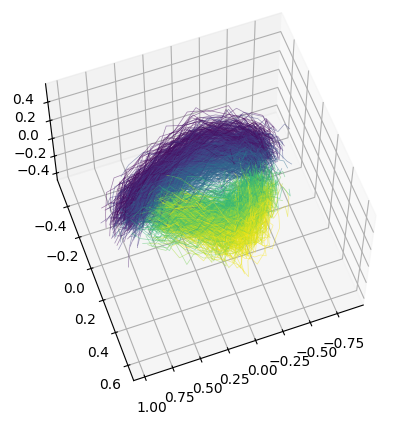

In [4]:

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
inputs_bump = inputs_to_env[:, 65, :]
bump_mag = inputs_bump[:,0]
bump_mag_norm = (bump_mag - bump_mag.min()) / (bump_mag.max() - bump_mag.min())
bump_pca = bump_pca.reshape(-1, window_end-window_start, 3)
for i in range(states.shape[0]):
    ax.plot(
        bump_pca[i,:, 0],
        bump_pca[i,:, 1],
        bump_pca[i,:, 2],
        linewidth=0.5,
        alpha=0.5,
        color=cm.viridis(bump_mag_norm[i]),
    )
# Set the view
ax.view_init(elev=60, azim=70)

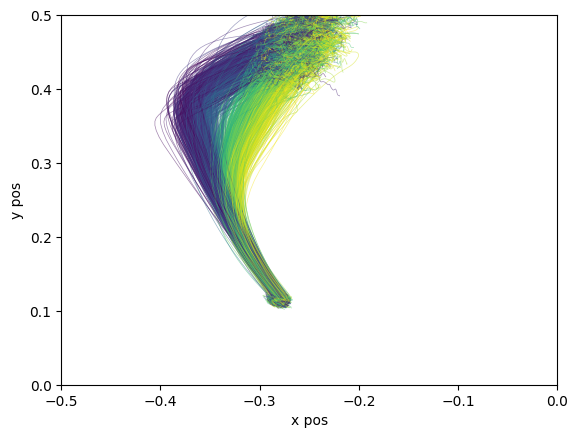

In [5]:
ctrl = controlled.detach().numpy()
fig_traj = plt.figure()
ax_traj = fig_traj.add_subplot(111)
for i in range(ctrl.shape[0]):
    ax_traj.plot(
        ctrl[i,30:, 0],
        ctrl[i,30:, 1],
        linewidth=0.5,
        alpha=0.5,
        color=cm.viridis(bump_mag_norm[i]),
    )
ax_traj.set_xlim(-0.5, 0)
ax_traj.set_ylim(0,0.5)
ax_traj.set_xlabel("x pos")
ax_traj.set_ylabel("y pos")
plt.savefig("bump_traj.pdf")


In [6]:
readout = an_TT.wrapper.model.readout.weight.detach().numpy()
controlled_window = controlled[:, window_start:window_end, :]
x_pos = controlled_window[:, :, 0].detach().numpy()
y_pos = controlled_window[:, :, 1].detach().numpy()
pec_readout = readout[0,:]
delt_readout = readout[1,:]

pec_proj = np.dot(bump_lats, pec_readout)
delt_proj = np.dot(bump_lats, delt_readout)
pec_proj = pec_proj.reshape(-1, window_end-window_start)
delt_proj = delt_proj.reshape(-1, window_end-window_start)



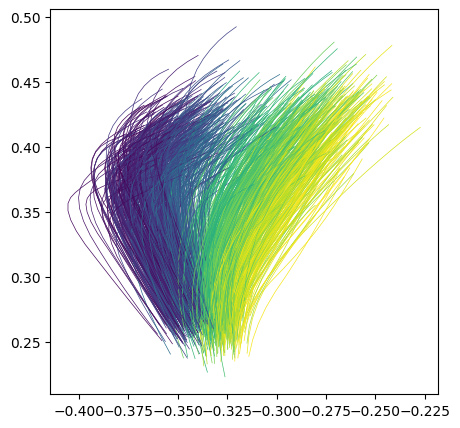

In [7]:
fig_xy = plt.figure(figsize=(5, 5))
ax_xy = fig_xy.add_subplot(111)
for i in range(states.shape[0]):
    ax_xy.plot(
        x_pos[i, :],
        y_pos[i, :],
        linewidth=0.5,
        color=cm.viridis(bump_mag_norm[i]),
    )

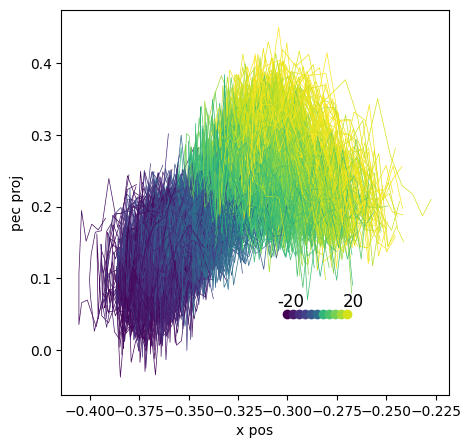

In [8]:
fig_pec = plt.figure(figsize=(5, 5))
ax_pec = fig_pec.add_subplot(111)
for i in range(states.shape[0]):
    ax_pec.plot(
        x_pos[i, :],
        pec_proj[i, :],
        linewidth=0.5,
        color=cm.viridis(bump_mag_norm[i]),
    )
# ax_pec.scatter(
#     x_pos[:, 0],
#     pec_proj[:, 0],
#     color="g",
# )
# ax_pec.scatter(
#     x_pos[:, -1],
#     pec_proj[:, -1],
#     color="r",
# )
sorted_bump_map_norm = np.argsort(bump_mag_norm)
sorted_bump = bump_mag_norm[sorted_bump_map_norm]
for i in range(0, bump_mag_norm.shape[0],100):
    ax_pec.scatter(
        -0.3 + 0.00003 * i,
        0.05,
        color=cm.viridis(sorted_bump[i]),
    )
ax_pec.text(-0.305, 0.06, "-20", fontsize=12)
ax_pec.text(-0.272, 0.06, "20", fontsize=12)
ax_pec.set_xlabel("x pos")
ax_pec.set_ylabel("pec proj")
plt.savefig("pec_proj.pdf")

Text(0, 0.5, 'delt proj')

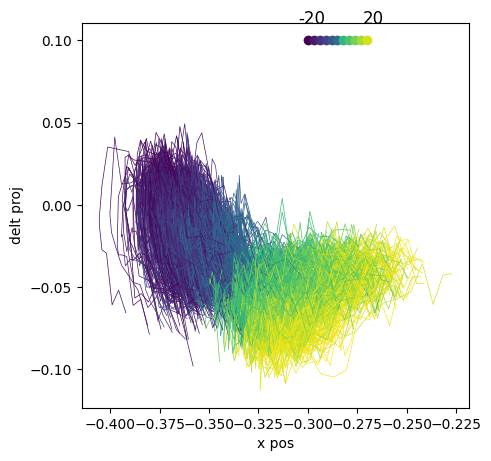

In [9]:
fig_delt = plt.figure(figsize=(5, 5))
ax_delt = fig_delt.add_subplot(111)
for i in range(states.shape[0]):
    ax_delt.plot(
        x_pos[i, :],
        delt_proj[i, :],
        linewidth=0.5,
        color=cm.viridis(bump_mag_norm[i]),
    )

sorted_bump_map_norm = np.argsort(bump_mag_norm)
sorted_bump = bump_mag_norm[sorted_bump_map_norm]

for i in range(0, bump_mag_norm.shape[0],100):
    ax_delt.scatter(
        -0.3 + 0.00003 * i,
        0.1,
        color=cm.viridis(sorted_bump[i]),
    )
ax_delt.text(-0.305, 0.11, "-20", fontsize=12)
ax_delt.text(-0.272, 0.11, "20", fontsize=12)
ax_delt.set_xlabel("x pos")
ax_delt.set_ylabel("delt proj")

In [10]:
dyn = an_TT.wrapper.model.cell
bump_lats = bump_lats.reshape(-1, window_end-window_start, latents.shape[-1])
bump_states = bump_states.reshape(-1, window_end-window_start, states.shape[-1])
bump_inputs = bump_inputs.reshape(-1, window_end-window_start, tt_inputs.shape[-1])
inputs_bump = inputs_bump.reshape(-1, inputs_to_env.shape[-1])

lats_sorted = torch.tensor(bump_lats[sorted_bump_map_norm, :])
inputs_sorted = torch.tensor(inputs_bump[sorted_bump_map_norm, :])
states_sorted = torch.tensor(bump_states[sorted_bump_map_norm, :])
goal_inputs_sorted = torch.tensor(bump_inputs[sorted_bump_map_norm, :])
full_inputs_sorted = torch.cat((states_sorted, goal_inputs_sorted), dim=2)
d_lats = torch.zeros(lats_sorted.shape)
lats_t = torch.zeros(lats_sorted.shape)
print(lats_sorted.shape)
for i in range(lats_sorted.shape[0]):
    lats_t[i,:,:] = dyn(full_inputs_sorted[i, :], lats_sorted[i, :])
lats_t_0 = lats_sorted
lats_t_0_flat = lats_t_0.reshape(-1, lats_t_0.shape[-1])

/tmp/ipykernel_2982578/598019216.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_sorted = torch.tensor(inputs_bump[sorted_bump_map_norm, :])
/tmp/ipykernel_2982578/598019216.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states_sorted = torch.tensor(bump_states[sorted_bump_map_norm, :])
/tmp/ipykernel_2982578/598019216.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  goal_inputs_sorted = torch.tensor(bump_inputs[sorted_bump_map_norm, :])


torch.Size([1100, 15, 128])


[0.11333011 0.12242755 0.07246102 ... 0.21708037 0.20166792 0.16877717]
[0.12518625 0.15066443 0.06888005 ... 0.25174606 0.2316924  0.17382325]


Text(0, 0.5, 'pec proj')

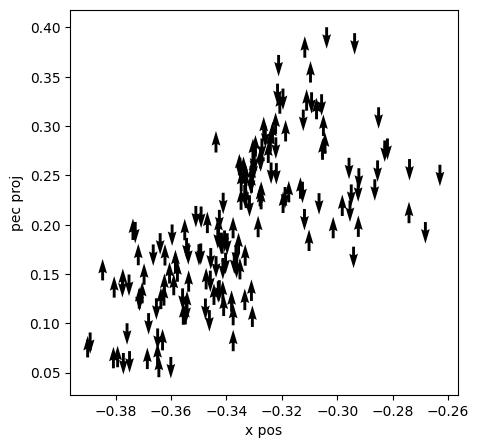

In [11]:
x_pos_sorted = x_pos[sorted_bump_map_norm, :]
x_pos_sorted_flat = x_pos_sorted.reshape(-1)
y_pos_sorted = y_pos[sorted_bump_map_norm, :]
y_pos_sorted_flat = y_pos_sorted.reshape(-1)

pec_proj_sorted = pec_proj[sorted_bump_map_norm, :]
pec_proj_sorted_flat = pec_proj_sorted.reshape(-1)
delt_proj_sorted = delt_proj[sorted_bump_map_norm, :]
delt_proj_sorted_flat = delt_proj_sorted.reshape(-1)

lats_t_flat = lats_t.reshape(-1, lats_t.shape[-1]).detach().numpy()
pec_t = np.dot(lats_t_flat, pec_readout)
pec_0 = np.dot(lats_t_0_flat, pec_readout)
print(pec_t)
print(pec_0)
d_lats_pec = np.dot(lats_t_flat, pec_readout) - np.dot(lats_t_0_flat, pec_readout)
d_lats_delt = np.dot(lats_t_flat, delt_readout) - np.dot(lats_t_0_flat, delt_readout)


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# Make a Quiver plot
for i in range(0, x_pos_sorted_flat.shape[0], 100):
    ax.quiver(
        x_pos_sorted_flat[i],
        pec_proj_sorted_flat[i],
        0,
        d_lats_pec[i],
    )
ax.set_xlabel("x pos")
ax.set_ylabel("pec proj")